# Microstate stats and their analysis

Analysis of microstate stats such as average lifespan, coverage, frequency of occurrence, and transition probabilities.

In [1]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display

from src.helpers import PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

WORKING_DIR = os.path.join(RESULTS_ROOT, "microstates")
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "microstates")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = False
PLOT_EXT = ".png"

In [2]:
# load data computed with `1-main_gfp_stats_and_ideal_no_mstates.py`
df = pd.read_csv(os.path.join(WORKING_DIR, "ms_stats.csv"), index_col=[0])
# divide session into PLA/PSI and time for plotting purposes
df[["condition", "time"]] = df["session"].str.split("-", expand=True)
# divide to filters
df_220 = df[df["ms_opts"] == "(2.0, 20.0, 4)"]
df_220 = df_220.sort_values(by=["condition", "time"])
df_140 = df[df["ms_opts"] == "(1.0, 40.0, 3)"]
df_140 = df_140.sort_values(by=["condition", "time"])

In [3]:
# Functions for computing, saving and displaying ANOVAs and posthoc tests


def diff_between_microstates(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Microstate differences: {dv}")
    print("==========")
    anova = pg.anova(data=df, dv=dv, between=["microstate"], detailed=False)
    if SAVE_RESULTS:
        anova.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_microstate_anova.csv")
        )
    print("ANOVA")
    display(anova)
    posthoc = pg.pairwise_tukey(data=df, dv=dv, between="microstate", effsize="cohen")
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_microstate_posthoc.csv")
        )
    print("Tukey HSD")
    display(posthoc)


def diff_between_time(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Time differences: {dv}")
    print("==========")
    anova = pg.rm_anova(data=df, dv=dv, within=["time", "condition"], subject="subject")
    if SAVE_RESULTS:
        anova.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_time_anova.csv")
        )
    print("RM ANOVA")
    display(anova)
    posthoc = pg.pairwise_ttests(
        data=df,
        dv=dv,
        within=["time", "condition"],
        subject="subject",
        effsize="cohen",
        padjust="bonf",
        return_desc=True,
    )
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_time_posthoc.csv")
        )
    print("Pairwise t-tests (showing only significant after Bonf. correction < 0.05)")
    display(posthoc[posthoc["p-corr"] <= 0.05])


def diff_between_time_and_microstates(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Time differences: {dv}")
    print("==========")
    for ms in np.unique(df["microstate"]):
        print("----------")
        print(f"microstate {ms}")
        print("----------")
        anova = pg.rm_anova(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["time", "condition"],
            subject="subject",
        )
        if SAVE_RESULTS:
            anova.round(5).to_csv(
                os.path.join(
                    WORKING_DIR, f"{dv}_microstate{ms}_{filt_str}filt_anova.csv"
                )
            )
        print("RM ANOVA")
        display(anova)
        posthoc = pg.pairwise_ttests(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["time", "condition"],
            subject="subject",
            effsize="cohen",
            padjust="bonf",
            return_desc=True,
        )
        if SAVE_RESULTS:
            posthoc.round(5).to_csv(
                os.path.join(
                    WORKING_DIR, f"{dv}_microstate{ms}_{filt_str}filt_posthoc.csv"
                )
            )
        print(
            "Pairwise t-tests (showing only significant after Bonf. correction < 0.05)"
        )
        display(posthoc[posthoc["p-corr"] <= 0.05])

In [4]:
## Functions for plotting and saving boxplots


def _plot_ttest_signi(
    where, df_for_max, ax, plot_for="time", x1_base=-0.2, x2_base=0.2
):
    y = df_for_max.max() * 1.02
    h = df_for_max.max() * 0.05
    col = plt.rcParams["text.color"]
    for _, row in where.iterrows():
        if plot_for == "time":
            pos = int(row["time"][-1]) - 1
        elif plot_for == "microstate":
            pos = string.ascii_uppercase.index(row["microstate"])
        else:
            raise ValueError(f"Unkown for: {plot_for}")
        x1, x2 = x1_base + pos, x2_base + pos
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        if row["p-corr"] < 0.001:
            text = "p < 0.000"
        else:
            text = f"p={row['p-corr']:.3f}"
        ax.text(
            (x1 + x2) * 0.5,
            y + h,
            text,
            ha="center",
            va="bottom",
            color=col,
        )


def plot_boxes(df, dv, filt_str, plot_signi=True):
    # individual "factors"
    _, axs = plt.subplots(1, 2, sharey=True)
    sns.boxplot(x="microstate", y=dv, data=df, hue="condition", ax=axs[0])
    sns.despine(trim=True)
    if plot_signi:
        sign = pg.pairwise_ttests(
            data=df,
            dv=dv,
            between=["microstate"],
            within=["condition"],
            padjust="Bonf",
            subject="subject",
            within_first=False,
        )
        # find significant
        where = sign[
            (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "microstate * condition")
        ]
        _plot_ttest_signi(
            where, df[dv], ax=axs[0], plot_for="microstate", x1_base=-0.2, x2_base=0.2
        )

    sns.boxplot(x="time", y=dv, data=df, hue="condition", ax=axs[1])
    sns.despine(trim=True)
    if plot_signi:
        sign = pg.pairwise_ttests(
            data=df,
            dv=dv,
            within=["time", "condition"],
            subject="subject",
            padjust="bonf",
        )
        # find significant
        where = sign[
            (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
        ]
        _plot_ttest_signi(
            where, df[dv], ax=axs[1], plot_for="time", x1_base=-0.2, x2_base=0.2
        )
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(PLOTTING_DIR, f"{dv}_boxplot_factors_{filt_str}filt{PLOT_EXT}"),
            bbox_inches="tight",
            transparent=True,
        )
    else:
        plt.show()

    # interaction
    _, axs = plt.subplots(1, len(np.unique(df["microstate"])), sharex=True, sharey=True)
    for i, ms in enumerate(np.unique(df["microstate"])):
        ax = axs[i]
        sns.boxplot(
            x="time",
            y=dv,
            data=df[df["microstate"] == ms],
            hue="condition",
            ax=ax,
        )
        ax.set_title(f"Microstate {ms}")
        sns.despine(trim=True)
        if plot_signi:
            sign = pg.pairwise_ttests(
                data=df[df["microstate"] == ms],
                dv=dv,
                within=["time", "condition"],
                subject="subject",
                padjust="bonf",
            )
            # find significant
            where = sign[
                (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
            ]
            _plot_ttest_signi(
                where,
                df[df["microstate"] == ms][dv],
                ax=ax,
                plot_for="time",
                x1_base=-0.2,
                x2_base=0.2,
            )
        plt.tight_layout()
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(PLOTTING_DIR, f"{dv}_boxplot_interaction_{filt_str}filt{PLOT_EXT}"),
            bbox_inches="tight",
            transparent=True,
        )
    else:
        plt.show()

## Average lifespan ~ 2-20Hz filter ~ 4 microstates

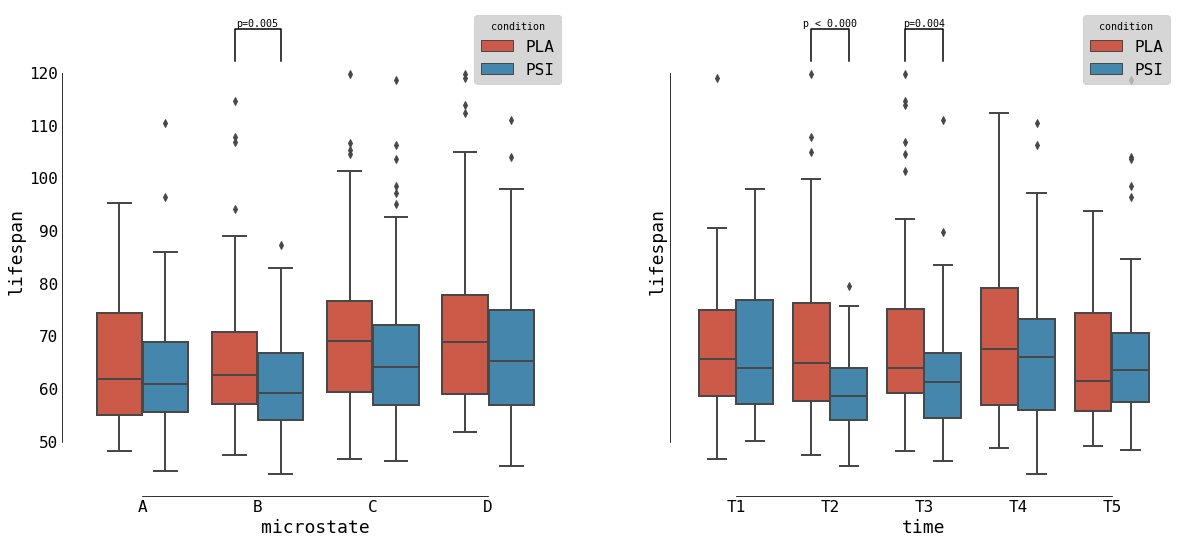

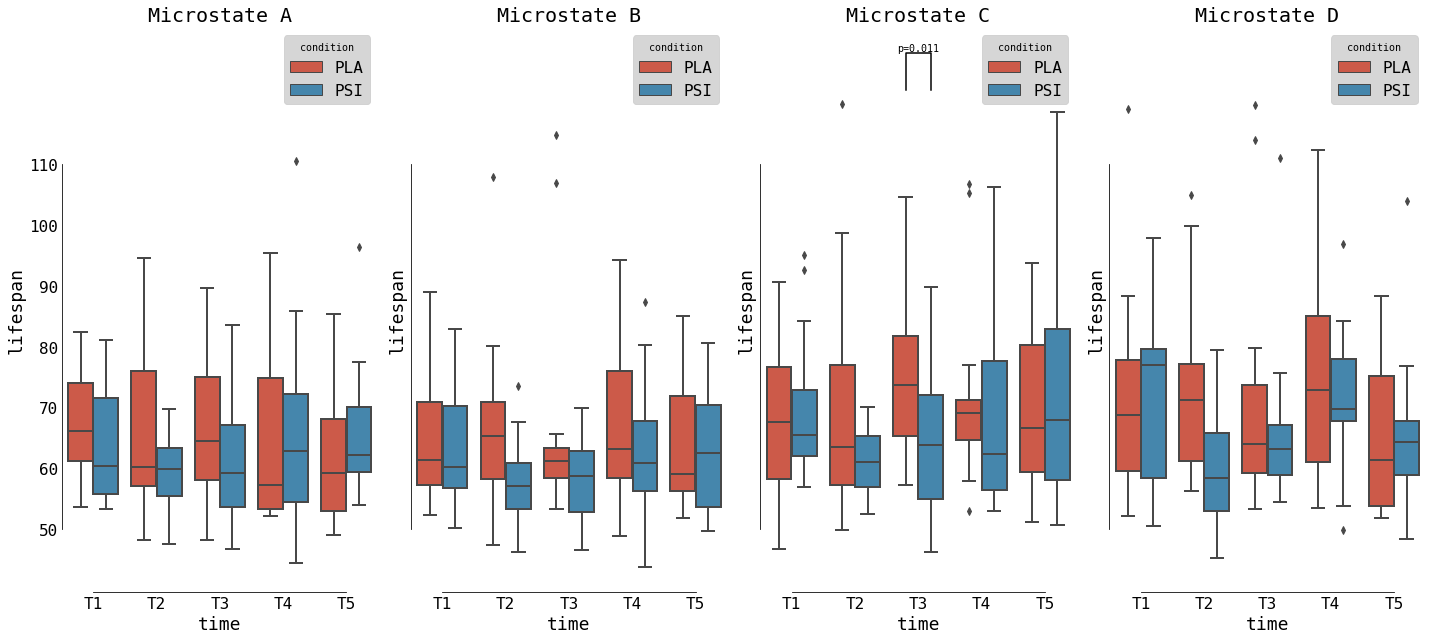

In [5]:
plot_boxes(df_220, "lifespan", "2-20")

### Differences between microstates

In [6]:
diff_between_microstates(df_220, "lifespan", filt_str="2-20")

Microstate differences: lifespan
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,7.68353,0.000048,0.037235


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,64.156421,63.587441,0.568980,1.550358,0.366999,0.900000,0.042377
1,A,C,64.156421,69.270231,-5.113809,1.550358,-3.298470,0.005442,-0.380874
2,A,D,64.156421,68.960273,-4.803852,1.550358,-3.098543,0.010601,-0.357789
3,B,C,63.587441,69.270231,-5.682790,1.550358,-3.665469,0.001435,-0.423252
4,B,D,63.587441,68.960273,-5.372833,1.550358,-3.465543,0.003019,-0.400166
5,C,D,69.270231,68.960273,0.309957,1.550358,0.199926,0.900000,0.023085


### Differences between times

In [7]:
diff_between_time(df_220, "lifespan", filt_str="2-20")

Time differences: lifespan
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,288.302934,4,56,72.075733,3.882233,0.007477,0.013253,0.217100,0.802742
1,condition,484.412117,1,14,484.412117,4.624547,0.049473,0.049473,0.248304,1.000000
2,time * condition,691.357668,4,56,172.839417,4.668963,0.002532,0.008876,0.250092,0.675912


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,67.454957,7.692758,64.162113,7.628156,True,True,3.529624,14.0,two-sided,0.003333,0.033331,bonf,13.903,0.429846
12,time * condition,T2,PLA,PSI,68.877250,15.705043,59.446975,7.275639,True,True,4.651813,59.0,two-sided,0.000019,0.000095,bonf,1006.364,0.770514
13,time * condition,T3,PLA,PSI,70.248643,16.569214,62.572909,11.449791,True,True,3.517838,59.0,two-sided,0.000844,0.004222,bonf,31.208,0.538972


### Significance of time / condition for each microstate

In [8]:
diff_between_time_and_microstates(df_220, "lifespan", filt_str="2-20")

Time differences: lifespan
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,157.401148,4,56,39.350287,0.609295,0.657625,0.558975,0.041706,0.527843
1,condition,154.452332,1,14,154.452332,1.928779,0.186591,0.186591,0.121088,1.000000
2,time * condition,698.169393,4,56,174.542348,1.888059,0.125264,0.143079,0.118835,0.785753


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,154.276253,4,56,38.569063,0.806497,0.526266,0.498143,0.054469,0.755770
1,condition,918.043687,1,14,918.043687,5.517983,0.034026,0.034026,0.282713,1.000000
2,time * condition,384.767954,4,56,96.191989,1.629423,0.179626,0.192513,0.104254,0.812771


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,589.936312,4,56,147.484078,1.979737,0.110113,0.120883,0.123890,0.869190
1,condition,456.170093,1,14,456.170093,1.592250,0.227623,0.227623,0.102118,1.000000
2,time * condition,1412.593729,4,56,353.148432,3.686066,0.009833,0.021107,0.208416,0.714463


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
13,time * condition,T3,PLA,PSI,75.576516,14.931266,64.355737,12.039382,True,True,3.762138,14.0,two-sided,0.002102,0.010512,bonf,20.528,0.827331


----------
microstate D
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,1105.691151,4,56,276.422788,2.642359,0.043015,0.053166,0.158773,0.852256
1,condition,573.707760,1,14,573.707760,1.900639,0.189638,0.189638,0.119532,1.000000
2,time * condition,831.297949,4,56,207.824487,1.337317,0.267510,0.276299,0.087194,0.700656


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
9,time,-,T4,T5,72.713378,12.12328,65.844726,10.666702,True,True,3.549102,14.0,two-sided,0.003207,0.032066,bonf,14.364,0.601551


## Coverage ~ 2-20Hz filter ~ 4 microstates

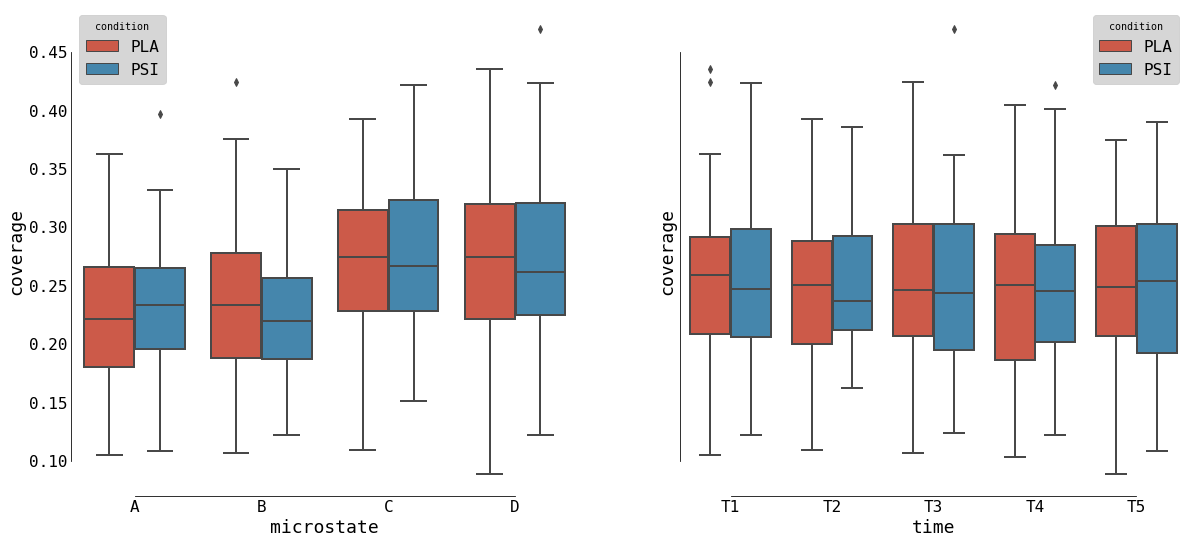

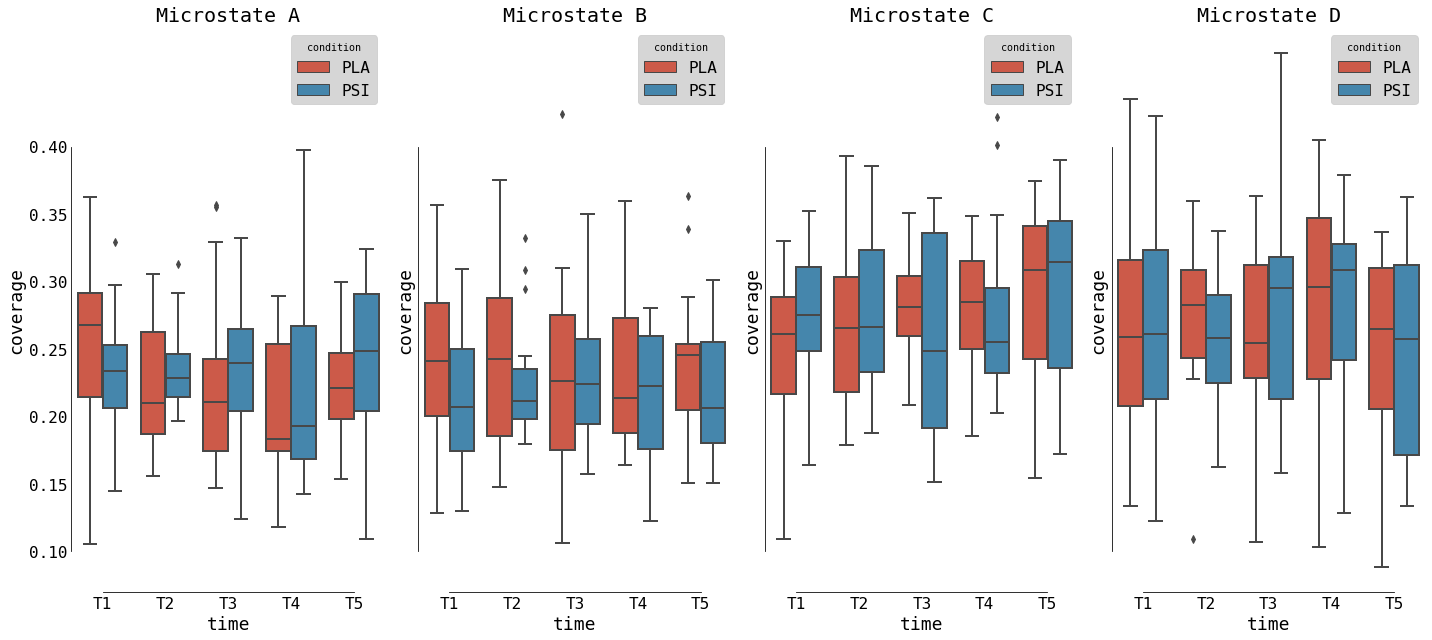

In [9]:
plot_boxes(df_220, "coverage", "2-20")

### Differences between microstates

In [10]:
diff_between_microstates(df_220, "coverage", filt_str="2-20")

Microstate differences: coverage
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,22.210989,1.206962e-13,0.100558


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,0.229666,0.228935,0.000732,0.007216,0.101399,0.90000,0.011709
1,A,C,0.229666,0.273915,-0.044248,0.007216,-6.131960,0.00100,-0.708058
2,A,D,0.229666,0.267484,-0.037818,0.007216,-5.240836,0.00100,-0.605160
3,B,C,0.228935,0.273915,-0.044980,0.007216,-6.233360,0.00100,-0.719766
4,B,D,0.228935,0.267484,-0.038550,0.007216,-5.342235,0.00100,-0.616868
5,C,D,0.273915,0.267484,0.006430,0.007216,0.891124,0.85364,0.102898


### Differences between time

In [11]:
diff_between_time(df_220, "coverage", filt_str="2-20")

Time differences: coverage
RM ANOVA


/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:713: RuntimeWarning: invalid value encountered in double_scalars
  f_b = ms_b / ms_bs


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.0,4,56,0.0,0.0,1.0,1.0,0.0,0.666667
1,condition,0.0,1,14,0.0,NaN,NaN,NaN,NaN,1.000000
2,time * condition,0.0,4,56,0.0,0.0,1.0,1.0,0.0,0.420711


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


### Significance of time / condition for each microstate

In [12]:
diff_between_time_and_microstates(df_220, "coverage", filt_str="2-20")

Time differences: coverage
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.013758,4,56,0.003440,1.577239,0.193030,0.210154,0.101253,0.733671
1,condition,0.002091,1,14,0.002091,0.495532,0.493013,0.493013,0.034185,1.000000
2,time * condition,0.007303,4,56,0.001826,0.472164,0.755928,0.718851,0.032626,0.816133


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.002069,4,56,0.000517,0.243679,0.912301,0.843303,0.017108,0.665789
1,condition,0.008036,1,14,0.008036,2.072254,0.171984,0.171984,0.128934,1.000000
2,time * condition,0.002352,4,56,0.000588,0.225118,0.923252,0.868718,0.015825,0.709987


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.018677,4,56,0.004669,1.285751,0.286598,0.291451,0.084114,0.767846
1,condition,0.001450,1,14,0.001450,0.274209,0.608712,0.608712,0.019210,1.000000
2,time * condition,0.014256,4,56,0.003564,0.967337,0.432701,0.422916,0.064630,0.832159


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.021680,4,56,0.005420,1.271972,0.291901,0.295797,0.083288,0.790957
1,condition,0.000034,1,14,0.000034,0.004778,0.945868,0.945868,0.000341,1.000000
2,time * condition,0.004806,4,56,0.001202,0.359040,0.836671,0.787081,0.025004,0.766524


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Frequency of occurrence ~ 2-20Hz filter ~ 4 microstates

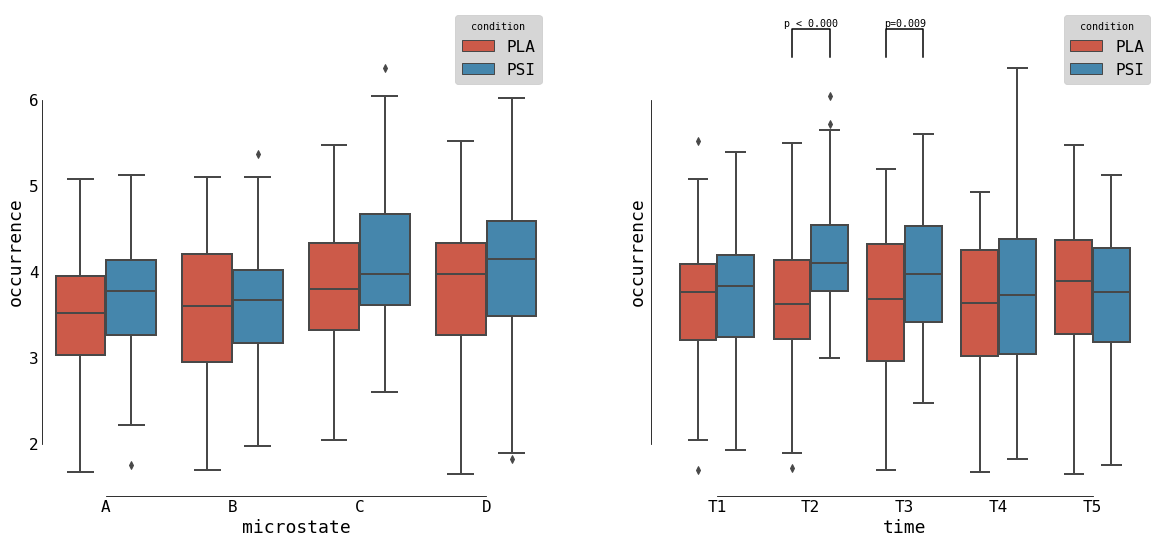

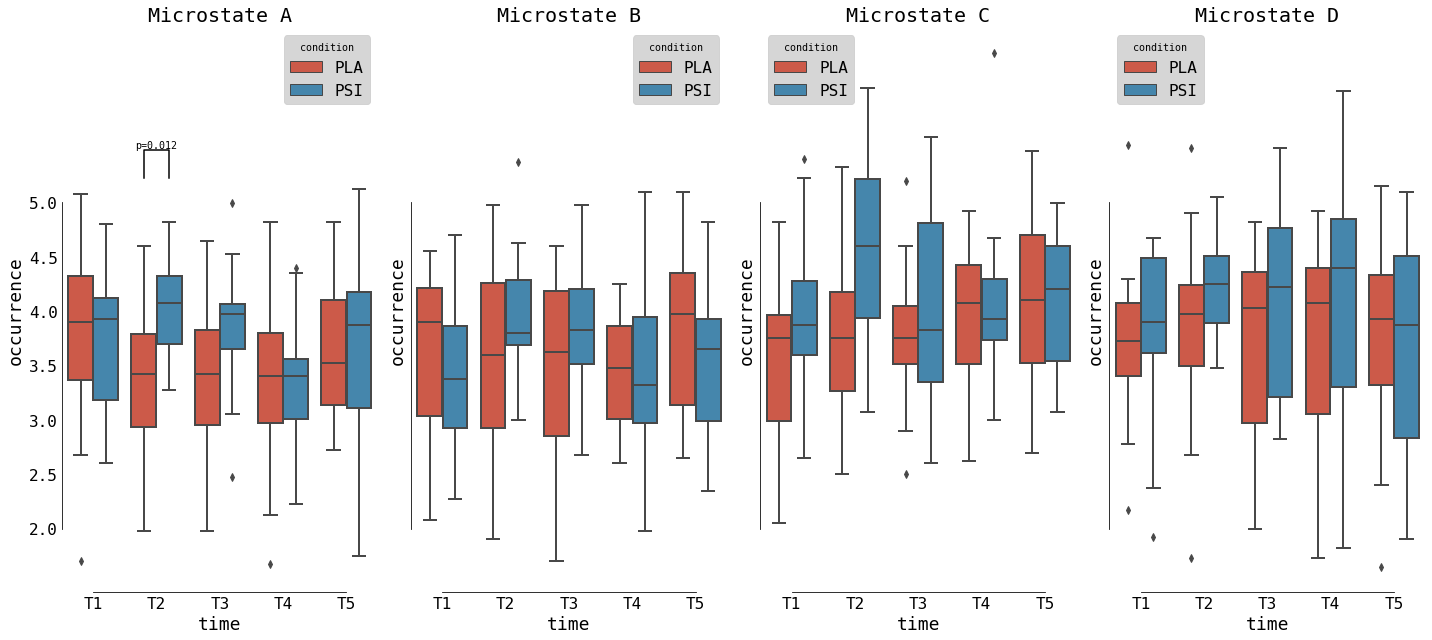

In [13]:
plot_boxes(df_220, "occurrence", "2-20")

### Differences between microstates

In [14]:
diff_between_microstates(df_220, "occurrence", filt_str="2-20")

Microstate differences: occurrence
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,9.57171,0.000004,0.045965


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,3.598149,3.612647,-0.014499,0.091652,-0.158191,0.900000,-0.018266
1,A,C,3.598149,3.993943,-0.395795,0.091652,-4.318446,0.001000,-0.498651
2,A,D,3.598149,3.897619,-0.299471,0.091652,-3.267472,0.006051,-0.377295
3,B,C,3.612647,3.993943,-0.381296,0.091652,-4.160254,0.001000,-0.480385
4,B,D,3.612647,3.897619,-0.284972,0.091652,-3.109281,0.010239,-0.359029
5,C,D,3.993943,3.897619,0.096324,0.091652,1.050973,0.811849,0.121356


### Differences betweet time

In [15]:
diff_between_time(df_220, "occurrence", filt_str="2-20")

Time differences: occurrence
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,1.171575,4,56,0.292894,4.779017,0.002181,0.004936,0.254487,0.795061
1,condition,1.481019,1,14,1.481019,5.741692,0.031095,0.031095,0.290841,1.000000
2,time * condition,1.871434,4,56,0.467858,4.946865,0.001738,0.005066,0.261091,0.745128


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,3.698805,0.415787,3.935449,0.418309,True,True,-4.378415,14.0,two-sided,0.000630,0.006305,bonf,57.571,-0.567423
12,time * condition,T2,PLA,PSI,3.679224,0.818319,4.191674,0.657108,True,True,-4.114789,59.0,two-sided,0.000122,0.000610,bonf,181.403,-0.690536
13,time * condition,T3,PLA,PSI,3.574651,0.807735,3.965863,0.773862,True,True,-3.259856,59.0,two-sided,0.001853,0.009265,bonf,15.425,-0.494591


### Significance of time / condition for each microstate

In [16]:
diff_between_time_and_microstates(df_220, "occurrence", filt_str="2-20")

Time differences: occurrence
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,3.389105,4,56,0.847276,3.245769,0.018269,0.028878,0.188207,0.786154
1,condition,1.765493,1,14,1.765493,2.350678,0.147512,0.147512,0.143766,1.000000
2,time * condition,2.559433,4,56,0.639858,1.498982,0.214901,0.224995,0.096715,0.818231


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
2,time,-,T1,T4,3.733802,0.513895,3.313010,0.555085,True,True,3.823063,14.0,two-sided,0.001864,0.018640,bonf,22.738,0.786694
12,time * condition,T2,PLA,PSI,3.413000,0.718738,4.006275,0.469896,True,True,-3.676976,14.0,two-sided,0.002488,0.012441,bonf,17.796,-0.977066


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,1.890572,4,56,0.472643,1.558593,0.198044,0.216354,0.100176,0.705911
1,condition,0.126125,1,14,0.126125,0.260863,0.617487,0.617487,0.018292,1.000000
2,time * condition,2.968812,4,56,0.742203,1.882992,0.126158,0.144491,0.118554,0.779568


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,3.574360,4,56,0.893590,2.723529,0.038324,0.052569,0.162856,0.793474
1,condition,3.211389,1,14,3.211389,4.856058,0.044793,0.044793,0.257533,1.000000
2,time * condition,3.425856,4,56,0.856464,1.698629,0.163202,0.176865,0.108202,0.815231


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,1.926065,4,56,0.481516,1.301678,0.280577,0.286995,0.085068,0.720561
1,condition,1.937638,1,14,1.937638,3.183747,0.096054,0.096054,0.185277,1.000000
2,time * condition,1.457824,4,56,0.364456,1.304700,0.279447,0.285702,0.085248,0.739485


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Average lifespan ~ 1-40Hz filter ~ 3 microstates

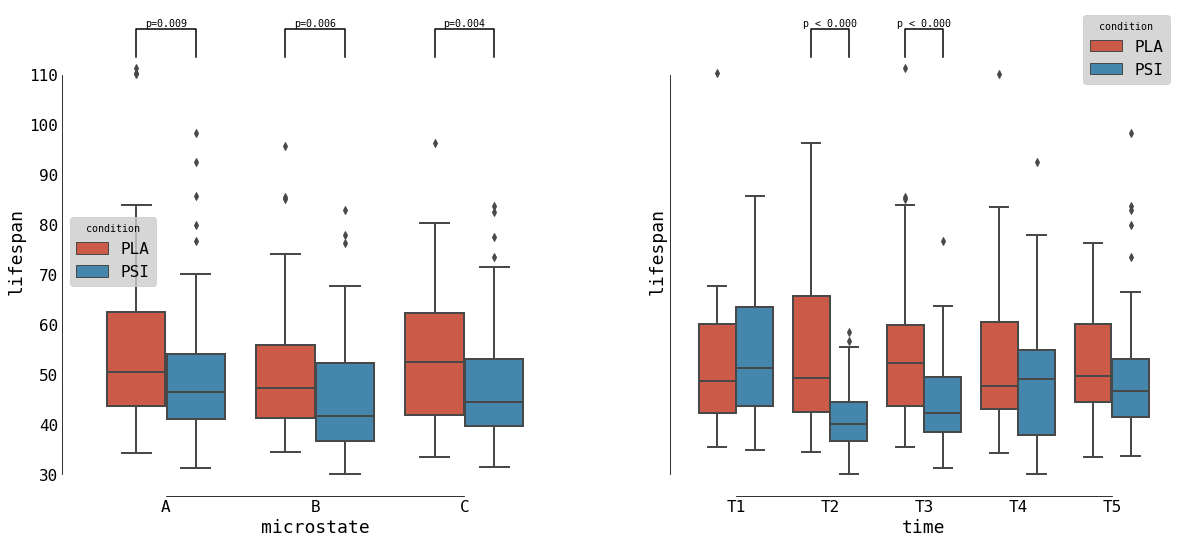

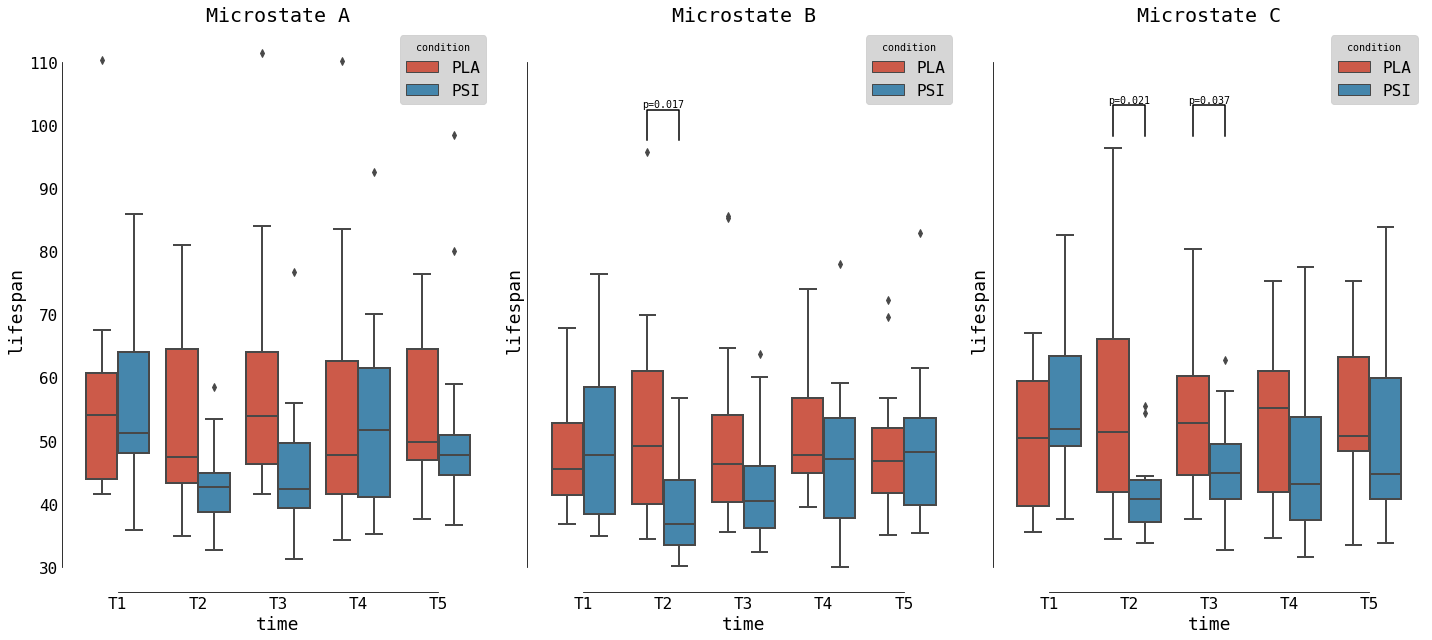

In [17]:
plot_boxes(df_140, "lifespan", "1-40")

### Differences between microstates

In [18]:
diff_between_microstates(df_140, "lifespan", filt_str="1-40")

Microstate differences: lifespan
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,4.560839,0.010944,0.019998


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,52.793901,48.054488,4.739413,1.584145,2.991780,0.007878,0.345461
1,A,C,52.793901,50.991392,1.802508,1.584145,1.137843,0.492159,0.131387
2,B,C,48.054488,50.991392,-2.936905,1.584145,-1.853937,0.152680,-0.214074


### Differences between time

In [19]:
diff_between_time(df_140, "lifespan", filt_str="1-40")

Time differences: lifespan
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,453.526216,4,56,113.381554,5.648214,0.000684,0.005868,0.287467,0.576029
1,condition,1134.355519,1,14,1134.355519,13.354625,0.002602,0.002602,0.488204,1.000000
2,time * condition,1072.576134,4,56,268.144034,7.433954,0.000071,0.001265,0.346831,0.597475


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,52.688797,9.434518,47.704282,8.146988,True,True,5.021907,14.0,two-sided,0.000187,0.001868,bonf,165.696,0.565504
12,time * condition,T2,PLA,PSI,53.990792,15.752126,41.417773,7.106458,True,True,5.545546,44.0,two-sided,0.000002,0.000008,bonf,1.1e+04,1.028933
13,time * condition,T3,PLA,PSI,55.047641,16.051662,44.399293,9.598195,True,True,4.592588,44.0,two-sided,0.000037,0.000183,bonf,593.222,0.805191


### Significance of time / condition for each microstate

In [20]:
diff_between_time_and_microstates(df_140, "lifespan", filt_str="1-40")

Time differences: lifespan
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,908.802568,4,56,227.200642,2.404706,0.060313,0.088919,0.146586,0.669603
1,condition,1434.533343,1,14,1434.533343,4.790926,0.046055,0.046055,0.254960,1.000000
2,time * condition,1045.994114,4,56,261.498528,2.419816,0.059032,0.100243,0.147372,0.556795


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,275.855243,4,56,68.963811,1.132799,0.350467,0.343906,0.074857,0.652242
1,condition,882.429456,1,14,882.429456,10.862147,0.005307,0.005307,0.436895,1.000000
2,time * condition,1053.051116,4,56,263.262779,3.534900,0.012155,0.020564,0.201592,0.788459


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,52.399738,16.481155,39.635905,8.320545,True,True,3.507508,14.0,two-sided,0.003483,0.017414,bonf,13.399,0.977706


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,450.330870,4,56,112.582718,1.757407,0.150385,0.158116,0.111529,0.898162
1,condition,1119.547254,1,14,1119.547254,9.577680,0.007914,0.007914,0.406218,1.000000
2,time * condition,1445.371992,4,56,361.342998,4.700486,0.002426,0.009116,0.251356,0.661482


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,55.642664,16.446008,41.522771,6.463102,True,True,3.406132,14.0,two-sided,0.004261,0.021303,bonf,11.312,1.130056
13,time * condition,T3,PLA,PSI,54.930332,12.911280,45.642920,8.013287,True,True,3.126070,14.0,two-sided,0.007437,0.037185,bonf,7.111,0.864340


## Coverage ~ 1-40Hz filter ~ 3 microstates

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:215: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


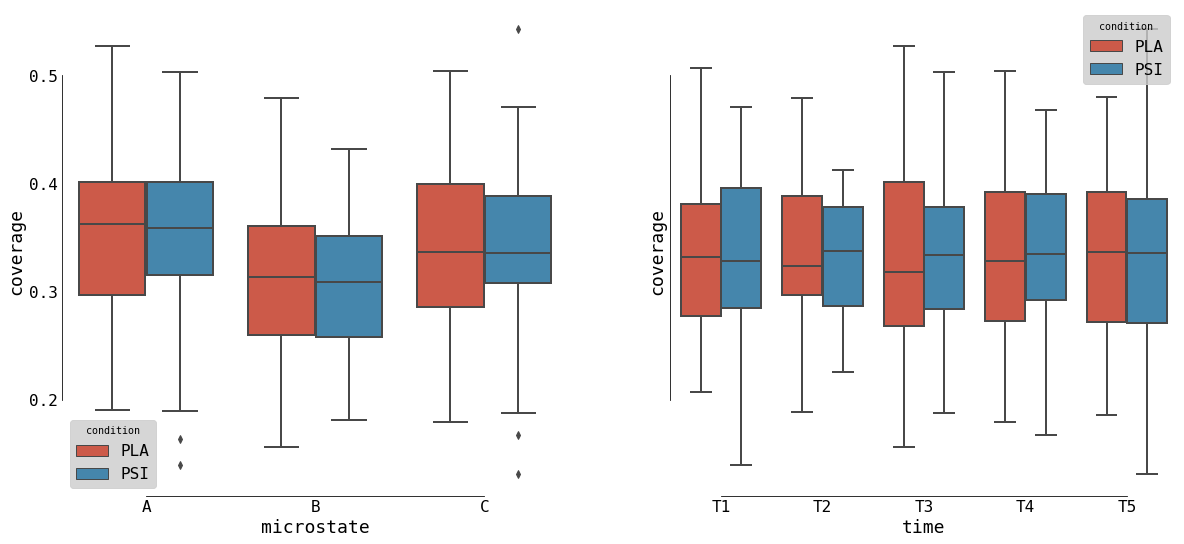

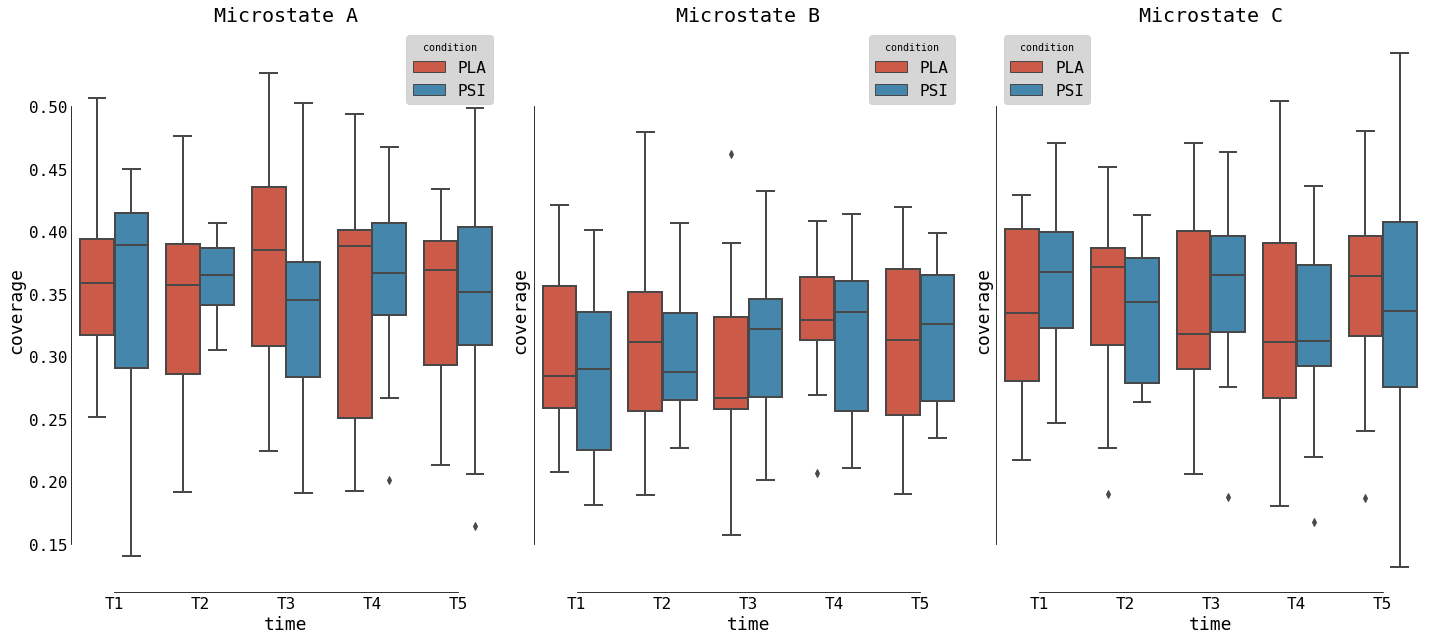

In [21]:
plot_boxes(df_140, "coverage", "1-40")

### Differences between microstates

In [22]:
diff_between_microstates(df_140, "coverage", filt_str="1-40")

Microstate differences: coverage
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,13.102895,0.000003,0.055379


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,0.349987,0.308997,0.04099,0.008419,4.868969,0.001000,0.56222
1,A,C,0.349987,0.341017,0.00897,0.008419,1.065471,0.582677,0.12303
2,B,C,0.308997,0.341017,-0.03202,0.008419,-3.803498,0.001000,-0.43919


### Differences between time

In [23]:
diff_between_time(df_140, "coverage", filt_str="1-40")

Time differences: coverage
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,4.622232e-31,4,56,1.155558e-31,-3.658537,1.0,1.0,-0.353774,0.358412
1,condition,7.395571e-30,1,14,7.395571e-30,-11.957295,1.0,1.0,-5.853659,1.000000
2,time * condition,-7.811572e-30,4,56,-1.952893e-30,-12.002029,1.0,1.0,-6.007109,0.805899


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:215: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


### Significance of time / condition for each microstate

In [24]:
diff_between_time_and_microstates(df_140, "coverage", filt_str="1-40")

Time differences: coverage
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.002498,4,56,0.000624,0.111162,0.978117,0.946041,0.007878,0.705183
1,condition,0.000009,1,14,0.000009,0.001374,0.970959,0.970959,0.000098,1.000000
2,time * condition,0.027566,4,56,0.006891,1.370675,0.255779,0.268752,0.089175,0.609936


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.012915,4,56,0.003229,0.861366,0.492855,0.474842,0.057960,0.807148
1,condition,0.000465,1,14,0.000465,0.151928,0.702565,0.702565,0.010735,1.000000
2,time * condition,0.009972,4,56,0.002493,0.598050,0.665551,0.624466,0.040968,0.772344


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.012222,4,56,0.003055,0.533047,0.711951,0.697121,0.036678,0.917998
1,condition,0.000344,1,14,0.000344,0.032219,0.860120,0.860120,0.002296,1.000000
2,time * condition,0.013663,4,56,0.003416,0.699641,0.595460,0.547356,0.047596,0.693424


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Frequency of occurrence ~ 1-40Hz filter ~ 3 microstates

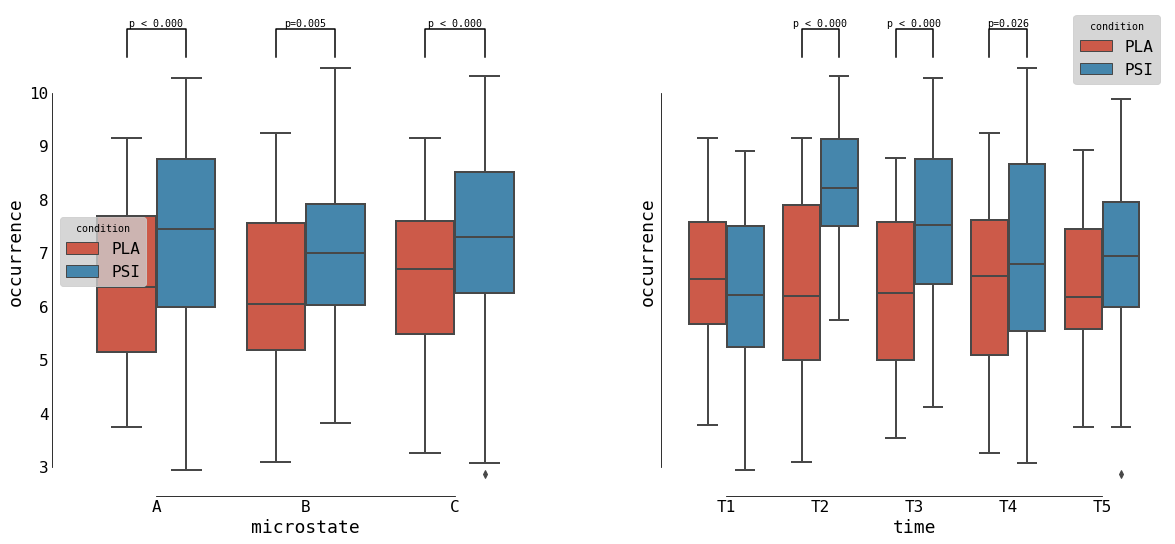

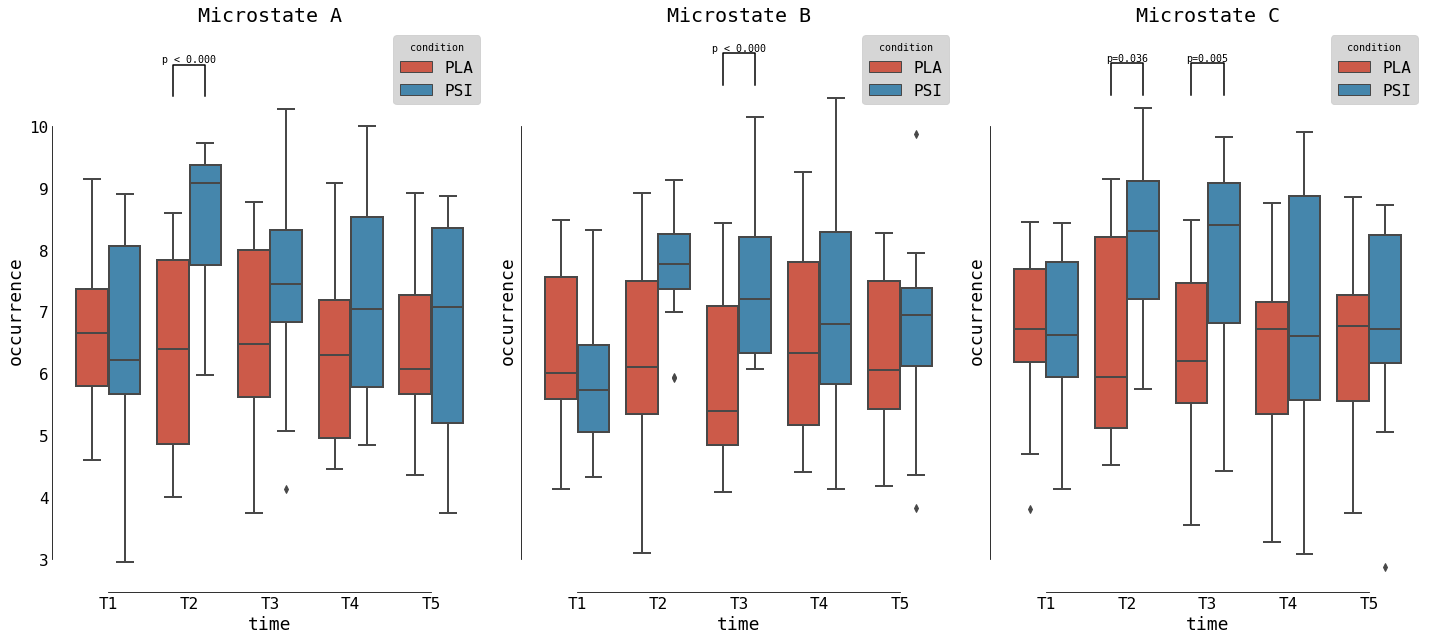

In [25]:
plot_boxes(df_140, "occurrence", "1-40")

### Differences between microstates

In [26]:
diff_between_microstates(df_140, "occurrence", filt_str="1-40")

Microstate differences: occurrence
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,1.29154,0.275871,0.005746


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,6.878495,6.631019,0.247476,0.183687,1.347271,0.370231,0.155569
1,A,C,6.878495,6.894160,-0.015665,0.183687,-0.085282,0.900000,-0.009847
2,B,C,6.631019,6.894160,-0.263141,0.183687,-1.432553,0.324753,-0.165417


### Differences between time

In [27]:
diff_between_time(df_140, "occurrence", filt_str="1-40")

Time differences: occurrence
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,12.375761,4,56,3.093940,8.401828,0.000022,0.001438,0.375051,0.495680
1,condition,21.039670,1,14,21.039670,29.543115,0.000088,0.000088,0.678480,1.000000
2,time * condition,18.922756,4,56,4.730689,9.193343,0.000009,0.000203,0.396379,0.655328


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.458258,1.130425,7.279289,1.090635,True,True,-5.403739,14.0,two-sided,9.298333e-05,9.298333e-04,bonf,305.491,-0.739196
1,time,-,T1,T3,6.458258,1.130425,6.929879,1.214356,True,True,-4.086852,14.0,two-sided,1.110287e-03,1.110287e-02,bonf,35.387,-0.402015
6,time,-,T2,T5,7.279289,1.090635,6.582690,1.240256,True,True,3.387251,14.0,two-sided,4.423670e-03,4.423670e-02,bonf,10.962,0.596483
12,time * condition,T2,PLA,PSI,6.423817,1.654399,8.134761,1.234414,True,True,-6.448358,44.0,two-sided,7.389482e-08,3.694741e-07,bonf,1.925e+05,-1.172207
13,time * condition,T3,PLA,PSI,6.246612,1.510705,7.613145,1.485569,True,True,-6.518228,44.0,two-sided,5.831769e-08,2.915885e-07,bonf,2.406e+05,-0.912123
14,time * condition,T4,PLA,PSI,6.443815,1.518607,7.068199,1.816445,True,True,-2.939528,44.0,two-sided,5.220271e-03,2.610136e-02,bonf,6.851,-0.372953


### Significance of time / condition for each microstate

In [28]:
diff_between_time_and_microstates(df_140, "occurrence", filt_str="1-40")

Time differences: occurrence
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,16.862165,4,56,4.215541,6.347443,0.000276,0.001542,0.311953,0.707378
1,condition,24.095398,1,14,24.095398,28.924980,0.000097,0.000097,0.673850,1.000000
2,time * condition,22.038820,4,56,5.509705,5.834078,0.000536,0.001763,0.294144,0.773588


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.538528,1.381851,7.459272,1.263571,True,True,-4.516497,14.0,two-sided,0.000484,0.004837,bonf,72.396,-0.695408
1,time,-,T1,T3,6.538528,1.381851,7.021814,1.460687,True,True,-3.389347,14.0,two-sided,0.004405,0.044053,bonf,11.0,-0.339908
12,time * condition,T2,PLA,PSI,6.401042,1.697350,8.517502,1.210529,True,True,-5.397557,14.0,two-sided,0.000094,0.000470,bonf,302.512,-1.435692


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,12.724556,4,56,3.181139,4.463047,0.003353,0.011412,0.241729,0.661909
1,condition,14.598749,1,14,14.598749,13.564722,0.002459,0.002459,0.492104,1.000000
2,time * condition,24.426004,4,56,6.106501,5.554536,0.000774,0.003067,0.284054,0.720714


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.146066,1.063776,6.993484,0.950657,True,True,-3.898183,14.0,two-sided,0.001607,0.016075,bonf,25.792,-0.840022
13,time * condition,T3,PLA,PSI,5.911089,1.432106,7.487602,1.282933,True,True,-5.470441,14.0,two-sided,0.000082,0.000412,bonf,339.478,-1.159570


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,12.593307,4,56,3.148327,3.175473,0.020179,0.037689,0.184884,0.697561
1,condition,25.312660,1,14,25.312660,14.543059,0.001899,0.001899,0.509513,1.000000
2,time * condition,16.998513,4,56,4.249628,4.563328,0.002924,0.009632,0.245825,0.681348


Pairwise t-tests (showing only significant after Bonf. correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,6.604355,1.698237,8.165869,1.452463,True,True,-3.144068,14.0,two-sided,0.007176,0.035879,bonf,7.325,-0.988215
13,time * condition,T3,PLA,PSI,6.231058,1.456385,7.905895,1.602254,True,True,-4.183766,14.0,two-sided,0.000919,0.004596,bonf,41.615,-1.093908
